In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import time

import numpy as np

import torch
import torch.nn.functional as F

import cv2

import matplotlib
import matplotlib.pyplot as plt

from viz_svls import LS, SVLS
from datasets import get_datasets_brats

In [2]:
DATA_PATH = '/home/s2018013343/project/exp4_dl/SVLS/MICCAI_BraTS_2019_Data_Training/HGG_LGG'

train_dataset, val_dataset = get_datasets_brats(data_root=DATA_PATH)

In [13]:
ls = LS(4, 0.1).cuda()
svls = SVLS(4, 1.0).cuda()

选取样本

In [14]:
sample_idx = 80

item = train_dataset[sample_idx]
label = item['label'].cuda()
image = item['image'].float().cuda()

label_oh = torch.permute(F.one_hot(label), (0, 4, 1, 2, 3))
label_ls = ls(label)
label_svls = svls(label)

label_oh_ = label_oh.cpu().numpy()
label_ls_ = label_ls.cpu().numpy()
label_svls_ = label_svls.cpu().numpy()

print(label_oh_.shape)
print(label_ls_.shape)
print(label_svls_.shape)

(1, 4, 128, 192, 192)
(1, 4, 128, 192, 192)
(1, 4, 128, 192, 192)


可视化样本

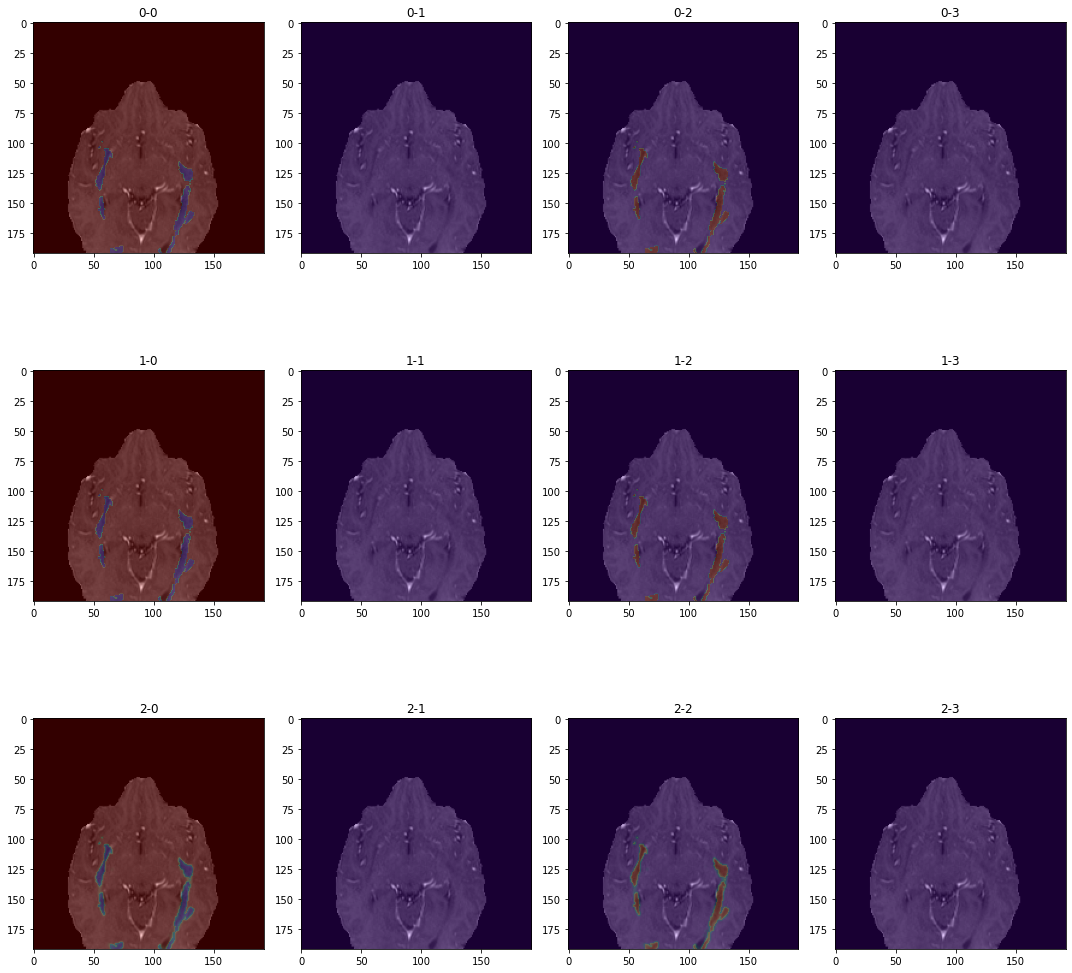

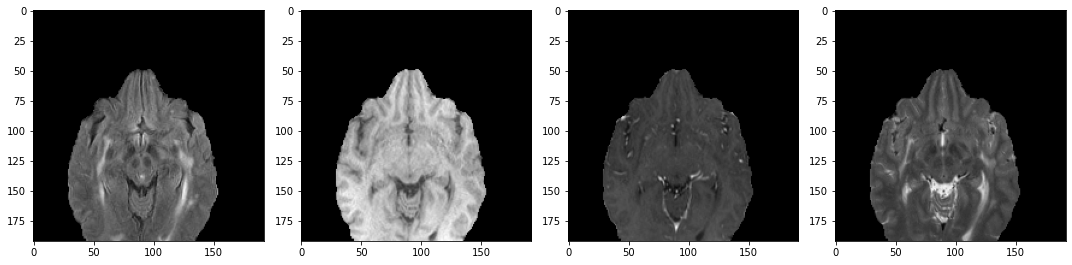

In [15]:
depth = 50

label_slice_oh = label_oh[0, :, depth, ...].cpu().numpy()
label_slice_ls = label_ls[0, :, depth, ...].cpu().numpy()
label_slice_svls = label_svls[0, :, depth, ...].cpu().numpy()


image_slice = image[:, depth, ...].cpu().numpy()


figure, axs = plt.subplots(3, 4, figsize=(15, 15))

_slices = [label_slice_oh, label_slice_ls, label_slice_svls]

for _type in range(3):
    _slice = _slices[_type]
    for _class in range(4):
        # print(f'{_type}-{_class}')
        # print(np.unique(_slice[_class+1]))
        axs[_type, _class].imshow(_slice[_class], cmap='rainbow')
        axs[_type, _class].imshow(image_slice[2], alpha=0.8, cmap='gray')
        axs[_type, _class].set_title(f'{_type}-{_class}')
plt.tight_layout()
plt.show()

figure, axs = plt.subplots(1, 4, figsize=(15, 15))
for seq in range(4):
    axs[seq].imshow(image_slice[seq], cmap='gray')
plt.tight_layout()
plt.show()

In [6]:
from svls import CELossWithSVLS, CELossWithSVLS_V6

svls = CELossWithSVLS(classes=4).cuda()
svls_v6 = CELossWithSVLS_V6(classes=4, scale_factor=2.2).cuda()

In [7]:
dummy = torch.rand((1, 4, 128, 192, 192)).float().cuda()

output_svls = svls(dummy, label)

output_svls_v6 = svls_v6(dummy, label)

/home/s2018013343/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


In [8]:
print(output_svls.shape)

print(output_svls_v6.shape)

print(output_svls_v6 - output_svls)

torch.Size([])
torch.Size([])
tensor(-0.0217, device='cuda:0')


In [9]:
label.shape

torch.Size([1, 128, 192, 192])

IndexError: too many indices for array: array is 0-dimensional, but 3 were indexed

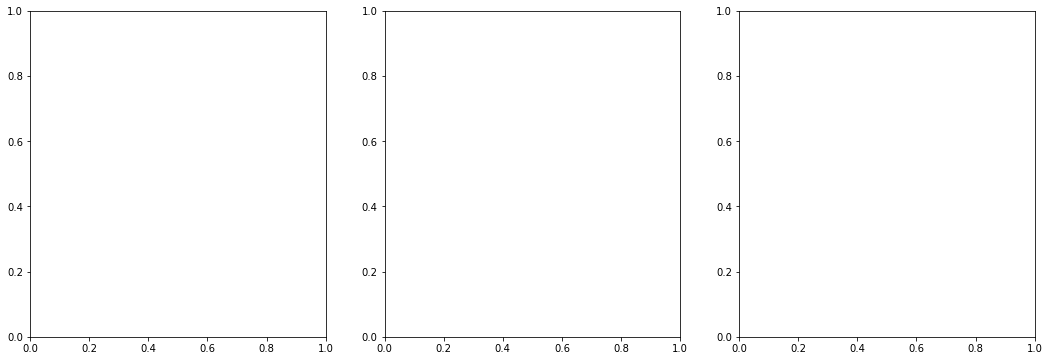

In [10]:
label_svls_v6_np = output_svls_v6.cpu().numpy()
label_svls_np = output_svls.cpu().numpy()
diff = label_svls_v6_np - label_svls_np

depth = 64

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
ax1, ax2, ax3 = axs.ravel()

ax1.imshow(label_svls_np[0, 2, depth], cmap='rainbow')
ax1.set_title('label_svls')
ax2.imshow(label_svls_v6_np[0, 2, depth], cmap='rainbow')
ax2.set_title('label_svls_v6')
# ax3_ = ax3.imshow(diff[0, 2, depth], cmap='rainbow')
# ax3.set_title("v6 - normal")
# plt.colorbar(ax3_, ax=ax3)

plt.tight_layout()
plt.show()

In [11]:
from svls import get_gaussian_filter

filter = get_gaussian_filter(sigma=0.5)

print(filter)

filter = filter / torch.sum(filter)

print(filter)

filter[1, 1, 1] = 1 - filter[1, 1, 1]

filter = filter / filter[1, 1, 1]

print(filter)

filter = filter / torch.sum(filter)

print(filter)

tensor([[[0.0016, 0.0117, 0.0016],
         [0.0117, 0.0862, 0.0117],
         [0.0016, 0.0117, 0.0016]],

        [[0.0117, 0.0862, 0.0117],
         [0.0862, 0.6366, 0.0862],
         [0.0117, 0.0862, 0.0117]],

        [[0.0016, 0.0117, 0.0016],
         [0.0117, 0.0862, 0.0117],
         [0.0016, 0.0117, 0.0016]]])
tensor([[[0.0012, 0.0089, 0.0012],
         [0.0089, 0.0660, 0.0089],
         [0.0012, 0.0089, 0.0012]],

        [[0.0089, 0.0660, 0.0089],
         [0.0660, 0.4874, 0.0660],
         [0.0089, 0.0660, 0.0089]],

        [[0.0012, 0.0089, 0.0012],
         [0.0089, 0.0660, 0.0089],
         [0.0012, 0.0089, 0.0012]]])
tensor([[[0.0024, 0.0174, 0.0024],
         [0.0174, 0.1287, 0.0174],
         [0.0024, 0.0174, 0.0024]],

        [[0.0174, 0.1287, 0.0174],
         [0.1287, 1.0000, 0.1287],
         [0.0174, 0.1287, 0.0174]],

        [[0.0024, 0.0174, 0.0024],
         [0.0174, 0.1287, 0.0174],
         [0.0024, 0.0174, 0.0024]]])
tensor([[[0.0012, 0.0087, 0.0012],
  